# VISUALIZE
This file deals with RMSE

It is simpler than visualize_emergent.

It loads the trajectories for the defined models (model_labels). 

The trajectories are also all combined into "all_multi_trajs" and "all_single_trajs", which is how we compute the average performance across models. We concatenate the N scenes (for example 200) generated from each model, resulting in N * N_models scenes in those combined trajectories (6 for the default case).

The RMSE are actually computed in the environment, so it is pretty straightforward to extract them, with most of the remaining code being for plotting.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os

import utils
import visualize_utils

In [2]:
model_labels = [
    'singleagent_def_1_fine',
    'singleagent_def_2_fine',
    'singleagent_def_3_fine',
    'multiagent_curr_1_fine',
    'multiagent_curr_2_fine',
    'multiagent_curr_3_fine'
]

In [3]:
traj_lab_dict = visualize_utils.get_trajs_dict(model_labels)

## traj_lab_dict Structure:

* for each model, a tuple of (trajectories, labels) that are returned from utils.load_trajs_labels()
    
    * trajectories is a list 
    
        * there is a list element for each dataset (e.g. i101_750_805, i101_805_815..., so 6 elements)
        
            * This is determined from the validate run. Each dataset that we generate trajectories for (filenames variable in the main function for validate.py)
        
        * each list element is an ndarry of shape (T,), where T = number of simulations run. 
                * This is determined in validate.py, as run_args.n_multiagent_trajs / args.n_envs. For n_trajs = 10000, n_vehs = 100, T = 100.
        
                * validate.py produces a total of run_args.n_multiagent_trajs trajectories. From each initial sample scene, we simulate 1 trajectory for each agent. Thus, n_vehs trajectories. Therefore, we need to run T simulations. 
         
            * each item in the array is a dictionary, of trajectory 'characteristics'
            
               * a trajectory component is something like, observations, actions:
           
                   * dict_keys(['rewards', 'rmse_t', 'prev_action', 'x', 'observations', 'mean', 'is_colliding', 'actions', 'y', 'log_std', 'rmse_vel', 'rmse_pos', 'phi', 's'])
                  
                   * the values are an array of shape (H, N, K), where H = the env_H (length of a trajectory or number of timesteps). N = number of agents. K is a third dimension, for things like observations (for which K=64). For something like rmse_t, K doesn't exist (array of shape (H, N)).
                   
                   * There is essentially a dictionary for every intial scene that we sampled. 
    
    - labels is a list
    
        * There is also an element for each dataset, like for trajectories. So, 6 in the default case we have.
    
            + ['0750am-0805am', '0805am-0820am', '0820am-0835am', '0400-0415', '0500-0515', '0515-0530']
    
        

In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
all_multi_trajs = visualize_utils.combine_trajs([traj_lab_dict[model_label][0] for model_label in model_labels if 'multi' in model_label])
all_single_trajs = visualize_utils.combine_trajs([traj_lab_dict[model_label][0] for model_label in model_labels if 'single' in model_label])

In [5]:
def visualize_trajectories(trajs, length, label='', color='blue', attr='rmse', style='solid'):
    rmses = []
    for traj in trajs:
        if len(traj[attr]) == length:
            #print(traj[attr].shape) # 200 x 50
            #print(np.mean(traj[attr],axis=1).shape) # 200 x 1
            # here we want to simply act as though all of the trajectories are independent. 
            # We no longer care that they were from the same scene.
            for veh_i in range(traj[attr].shape[1]):
                rmses.append(traj[attr][:,veh_i])
    rmses = np.array(rmses)
    mean = np.mean(rmses, axis=0)
    bound = np.std(rmses, axis=0) / np.sqrt(len(rmses)) / 2
    x = range(len(mean))
    plt.fill_between(x, mean - bound, mean + bound, alpha=.4, color=color)
    plt.plot(x, mean, c=color, label='mean {}: {:.5f}'.format(attr, np.mean(rmses)), linestyle=style)
    plt.xlabel('timesteps')
    plt.ylabel(attr)
    plt.title(label)
    plt.legend()

In [6]:
def plot_validation(trajs, labels, color='blue', length=200, attr='rmse', style='solid'):
    trajs = [
        trajs[0],
        np.concatenate((trajs[1], trajs[2])),
        np.concatenate((trajs[3], trajs[4], trajs[5]))
    ]
    labels = [
        labels[0],
        labels[1] + ' ' + labels[2],
        labels[3] + ' ' + labels[4] + ' ' + labels[4] 
    ]
    for i, traj in enumerate(trajs):
        plt.subplot(1,3,i+1)
        visualize_trajectories(traj, length, labels[i], attr=attr, color=color, style=style)

In [7]:
print(model_labels)

['singleagent_def_1_fine', 'singleagent_def_2_fine', 'singleagent_def_3_fine', 'multiagent_curr_1_fine', 'multiagent_curr_2_fine', 'multiagent_curr_3_fine']


# Run the below after redefining/reloading the models

singleagent_def_1_fine blue dotted
singleagent_def_2_fine red dotted
singleagent_def_3_fine magenta dotted
multiagent_curr_1_fine blue solid
multiagent_curr_2_fine red solid
multiagent_curr_3_fine magenta solid


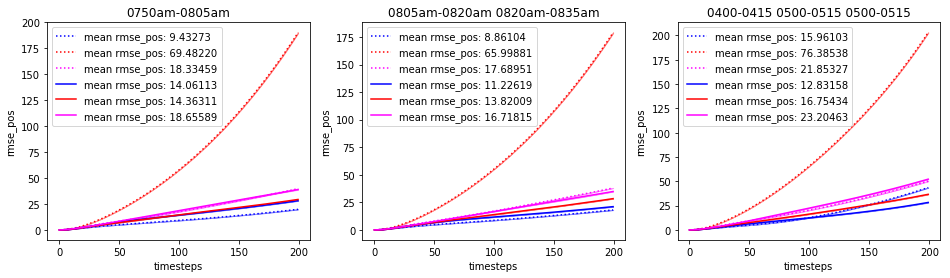

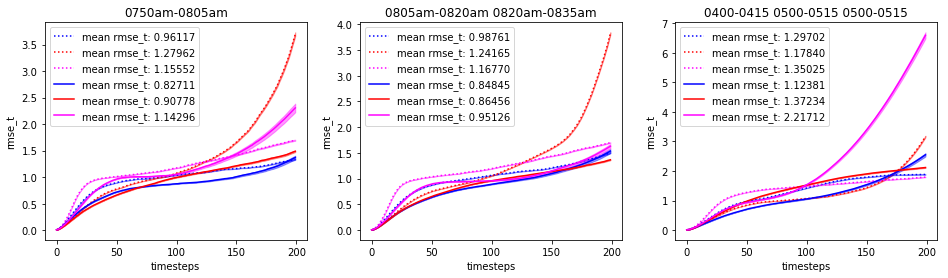

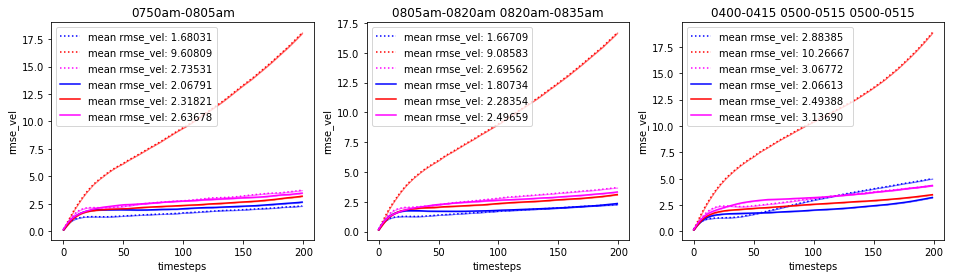

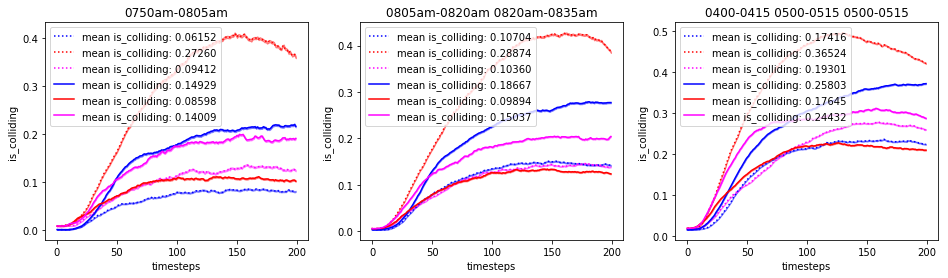

In [8]:
attrs = ['rmse_pos', 'rmse_t', 'rmse_vel', 'is_colliding']
colors = {
    'singleagent_def_1_fine': 'blue',
    'singleagent_def_2_fine': 'red',
    'singleagent_def_3_fine': 'magenta',
    'multiagent_curr_1_fine': 'blue',
    'multiagent_curr_2_fine': 'red',
    'multiagent_curr_3_fine': 'magenta'
}
for i, label in enumerate(model_labels):
    style = 'dotted'
    if 'multi' in label: style = 'solid'
    print(label, colors[label], style)


length = 200
ngsim_labels = traj_lab_dict[model_labels[0]][1]
for attr in attrs:
    plt.figure(figsize=(16,4))
    for i, label in enumerate(model_labels):
        style = 'dotted'
        if 'multi' in label: style = 'solid'
        plot_validation(traj_lab_dict[label][0], ngsim_labels, 
                    color=colors[label], attr=attr, style=style, length=length)
    plt.savefig(attr + '.png')
    plt.show()


In [ ]:
attrs = ['rmse_pos', 'rmse_t', 'rmse_vel', 'is_colliding']
ngsim_labels = traj_lab_dict[model_labels[0]][1]
for attr in attrs:
    plt.figure(figsize=(16,4))
    plot_validation(all_single_trajs, ngsim_labels, color='black', attr=attr, style='dotted', length=length)
    plot_validation(all_multi_trajs, ngsim_labels, color='black', attr=attr, style='solid', length=length)

    plt.savefig(attr + '_just_avg.png')
    plt.show()



In [ ]:
def get_means(trajs, length, attr='rmse'):
    rmses = []
    for traj in trajs:
        if len(traj[attr]) == length:
            for veh_i in range(traj[attr].shape[1]):
                rmses.append(traj[attr][:,veh_i])
    rmses = np.array(rmses)
    mean = np.mean(rmses, axis=0)
    x = range(len(mean))
    return (x, mean)

In [ ]:
def save_data(trajs, labels, length=200, attr='rmse', name='single'):
    trajs = [
        trajs[0],
        np.concatenate((trajs[1], trajs[2])),
        np.concatenate((trajs[3], trajs[4], trajs[5]))
    ]
    labels = [
        labels[0],
        labels[1] + ' ' + labels[2],
        labels[3] + ' ' + labels[4] + ' ' + labels[4] 
    ]
    for i, traj in enumerate(trajs):
        (x, mean) = get_means(traj, length, attr=attr)
        fn = "_".join([name, labels[i].replace(" ", "_"), attr]) + ".csv"
        np.savetxt(fn, (x, mean), delimiter=",")

In [ ]:
attrs = ['rmse_pos', 'rmse_t', 'rmse_vel', 'is_colliding']
ngsim_labels = traj_lab_dict[model_labels[0]][1]
for attr in attrs:
    save_data(all_single_trajs, ngsim_labels, attr=attr, length=length, name='single_avg')
    save_data(all_multi_trajs, ngsim_labels, attr=attr, length=length, name='multi_avg')
